In [45]:
import os, sys

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
sys.path.append(str(Path.cwd().resolve().parent))

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import weight_norm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error

from preprocess import VN30, TARGETS, preprocess_v2

# Bước 1: Tiền xử lý dữ liệu

In [8]:
train_loader, valid_loader, test_loader, scaler = preprocess_v2('ACB', 'cnn', verbose=True)

Train shape: torch.Size([1094, 5, 30]), torch.Size([1094, 5])
Valid shape: torch.Size([121, 5, 30]), torch.Size([121, 5])


# Bước 2: Định nghĩa mô hình

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size=3, dilation=1, dropout=0.2):
        super().__init__()
        padding = ((kernel_size - 1) * dilation) // 2
        self.conv1 = nn.Conv1d(in_ch, out_ch, kernel_size,
                               padding=padding, dilation=dilation)
        self.bn1   = nn.BatchNorm1d(out_ch)
        self.conv2 = nn.Conv1d(out_ch, out_ch, kernel_size,
                               padding=padding, dilation=dilation)
        self.bn2   = nn.BatchNorm1d(out_ch)
        self.relu  = nn.ReLU()
        self.drop  = nn.Dropout(dropout)
        # nếu số kênh thay đổi, thêm 1×1 conv cho skip connection
        self.downsample = (nn.Conv1d(in_ch, out_ch, 1)
                           if in_ch != out_ch else None)

    def forward(self, x):
        res = x if self.downsample is None else self.downsample(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.drop(out)
        out = self.bn2(self.conv2(out))
        out = self.drop(out)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self,
                 n_channels=5,
                 window_size=30,
                 hidden_dim=64,
                 output_dim=5,
                 dropout=0.2):
        super().__init__()
        # 3 block residual với dilation tăng dần
        self.block1 = Block(n_channels, 32,
							kernel_size=5,
							dilation=1,
							dropout=dropout)
        self.block2 = Block(32, 64,
							kernel_size=3,
							dilation=2,
							dropout=dropout)
        self.block3 = Block(64, 64,
							kernel_size=3,
							dilation=4,
							dropout=dropout)

        # pooling và head
        self.pool = nn.AdaptiveAvgPool1d(1)   # (batch, C, 1)
        self.fc   = nn.Sequential(
            nn.Linear(64, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        # x: (batch, n_channels, window_size)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x).squeeze(-1)  # (batch, 64)
        return self.fc(x)             # (batch, output_dim)


# Bước 3: Huấn luyện mô hình

In [7]:
os.makedirs('checkpoints', exist_ok=True)
checkpoint_path = 'checkpoints/tcn.pth'

In [56]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TCN(
	num_inputs=5,
    num_channels=[8, 16, 32],
    kernel_size=3,
    dropout=0.2,
    output_dim=5
).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [57]:
best_val_loss = float('inf')
num_epochs = 200

for epoch in range(1, num_epochs + 1):
    # --- train ---
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss  = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    train_loss /= len(train_loader.dataset)

    # --- validate ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            val_loss += criterion(preds, y_batch).item() * X_batch.size(0)
    val_loss /= len(valid_loader.dataset)

    if epoch % 10 == 0:
        print(f"Epoch {epoch:02d}: train_loss={train_loss:.6f}, val_loss={val_loss:.6f}")

    # --- checkpoint ---
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print(f"  → Saved checkpoint | val_loss={val_loss:.6f}")

  → Saved checkpoint | val_loss=0.316600
  → Saved checkpoint | val_loss=0.245955
  → Saved checkpoint | val_loss=0.243610
  → Saved checkpoint | val_loss=0.241603
Epoch 10: train_loss=0.141314, val_loss=0.241930
  → Saved checkpoint | val_loss=0.240062
  → Saved checkpoint | val_loss=0.234515
  → Saved checkpoint | val_loss=0.225538
Epoch 20: train_loss=0.126615, val_loss=0.229437
  → Saved checkpoint | val_loss=0.216447
  → Saved checkpoint | val_loss=0.215003
  → Saved checkpoint | val_loss=0.209526
  → Saved checkpoint | val_loss=0.208591
Epoch 30: train_loss=0.119635, val_loss=0.207921
  → Saved checkpoint | val_loss=0.207921
  → Saved checkpoint | val_loss=0.206645
  → Saved checkpoint | val_loss=0.204931
  → Saved checkpoint | val_loss=0.203059
  → Saved checkpoint | val_loss=0.197883
Epoch 40: train_loss=0.114195, val_loss=0.204279
  → Saved checkpoint | val_loss=0.196635
  → Saved checkpoint | val_loss=0.193847
Epoch 50: train_loss=0.110812, val_loss=0.208437
  → Saved checkpo

In [58]:
# Load model
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

# Thu thập dự đoán và nhãn
all_preds   = []
all_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y_batch.numpy())

all_preds   = np.vstack(all_preds)   # (n_samples, 5)
all_targets = np.vstack(all_targets)

# Inverse scaling
all_preds_inv   = scaler.inverse_transform(all_preds)
all_targets_inv = scaler.inverse_transform(all_targets)

# Tính metrics
r2   = r2_score(all_targets_inv, all_preds_inv, multioutput='uniform_average')
mape = mean_absolute_percentage_error(all_targets_inv, all_preds_inv) * 100

print(f"Test R²: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}%")

Test R²: -1.8273
Test MAPE: 20.3769%


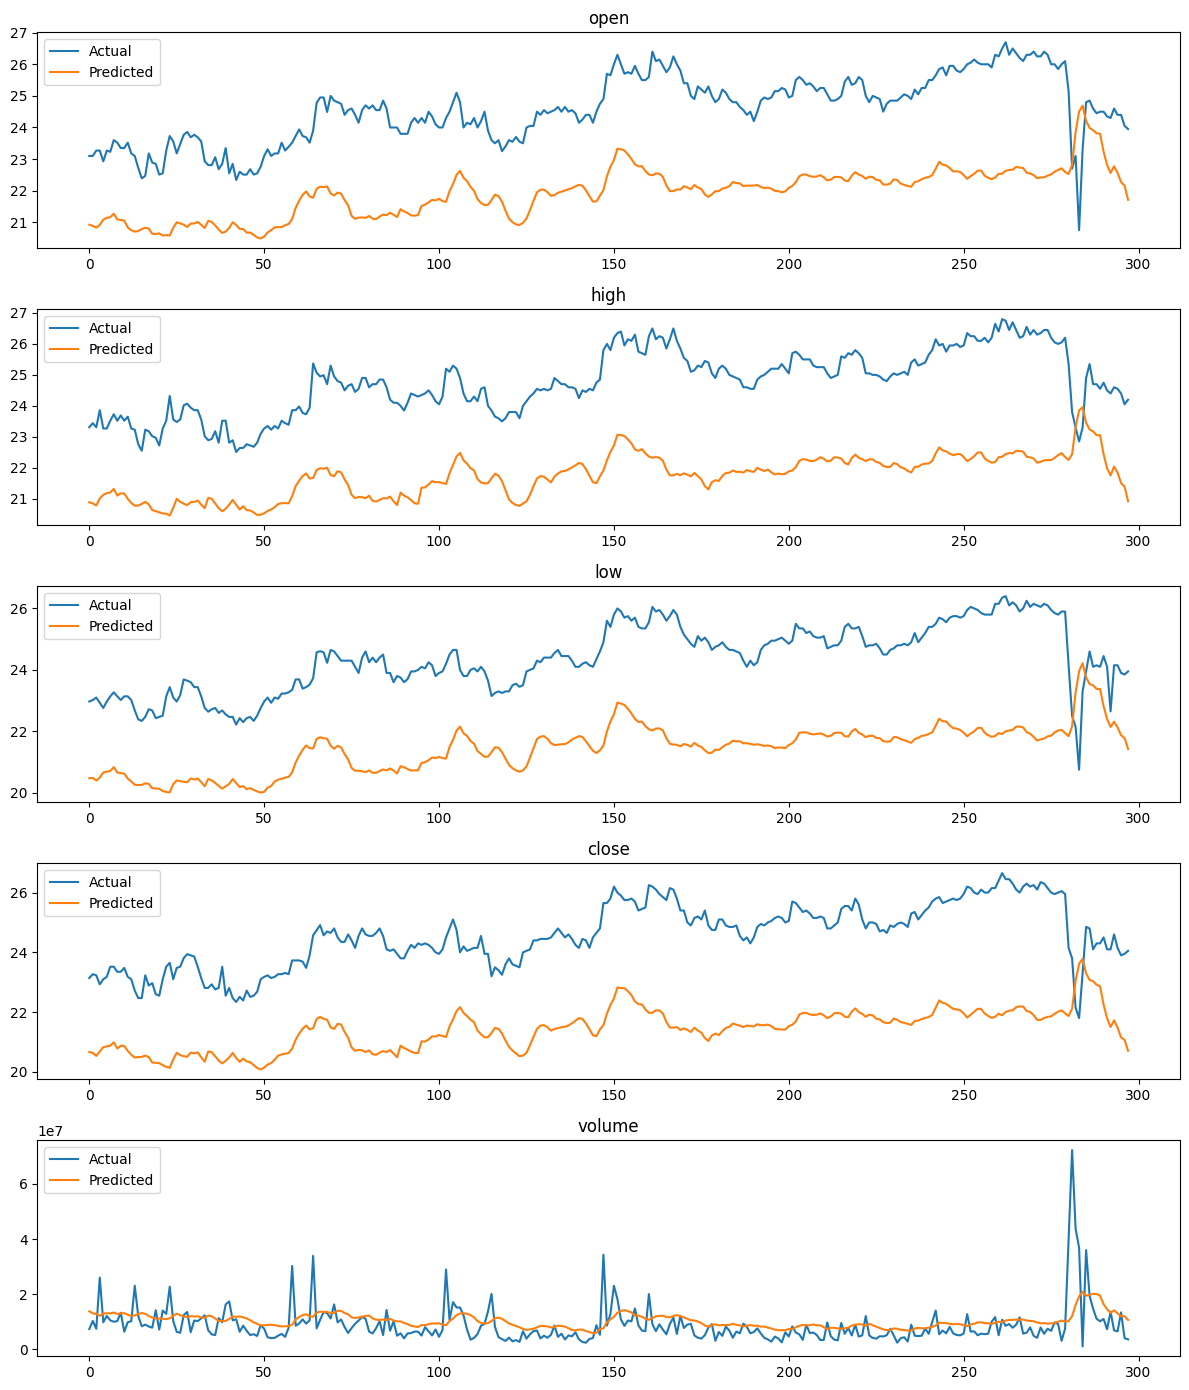

In [50]:
n = all_targets_inv.shape[1]

plt.figure(figsize=(12, 14))
for i in range(n):
    ax = plt.subplot(n, 1, i + 1)
    ax.plot(all_targets_inv[:, i], label='Actual')
    ax.plot(all_preds_inv[:, i],   label='Predicted')
    ax.set_title(TARGETS[i])
    ax.legend(loc='best')

plt.tight_layout()
plt.show()